In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px

# Data Import

In [ ]:
df = pd.read_csv

# Data exploration

In [ ]:
px.line(df/df.max(), title='Irradiance and Power')

In [ ]:
px.scatter(df, x='ghi', y='207', title='GHI vs Power')

# Modeling 

## Linear Regression with Pytorch & Stochastic Gradient Descent

In [ ]:

# Scaling and train/test split

df /= df.max() # scaling
train_ratio = 0.8
trg = df['207'].values
trg_train = trg[:int(len(trg)*train_ratio)]
trg_test = trg[int(len(trg)*train_ratio):]

cov = df.iloc[:, :3].values
cov_train = cov[:int(len(cov)*train_ratio)]
cov_test = cov[int(len(cov)*train_ratio):]



In [ ]:
# Into tensor format

trg_train = torch.from_numpy(trg_train).float().view(-1, 1)
trg_test = torch.from_numpy(trg_test).float().view(-1, 1)
cov_train = torch.from_numpy(cov_train).float().view(-1, 3)
cov_test = torch.from_numpy(cov_test).float().view(-1, 3)


In [ ]:
trg_train.shape

torch.Size([5800, 1])

In [ ]:
cov_train.shape

torch.Size([5800, 3])

In [ ]:
fan_in = cov_train.shape[1]
fan_out = trg_train.shape[1]

W = torch.randn(fan_in, fan_out, requires_grad=True)
b = torch.randn(fan_out, requires_grad=True)

In [ ]:
out = cov_train @ W + b

In [ ]:
loss = (out - trg_train).pow(2).mean()

loss.backward()

W.grad

tensor([[-0.6856],
        [-0.6331],
        [-0.8092]])

In [ ]:
W

tensor([[ 0.1891],
        [ 0.6532],
        [-2.1552]], requires_grad=True)

In [ ]:
#gradient descent
with torch.no_grad():
    W -= 0.001 * W.grad
    b -= 0.001 * b.grad

In [ ]:
## put it all in a loop 

W = torch.randn(fan_in, fan_out, requires_grad=True)
b = torch.randn(fan_out, requires_grad=True)


# lr schedule 
lr = 0.001 if i < 500 else 0.0001

lossi = []
for i in range(10000):
    out = cov_train @ W + b
    loss = (out - trg_train).pow(2).mean()
    loss.backward()
    lossi.append(loss.item())
    with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad
    W.grad.zero_()
    b.grad.zero_()

0.029340840876102448


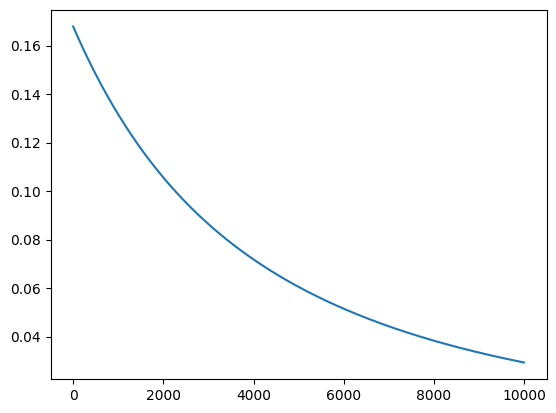

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossi)

print(min(lossi))

In [ ]:
# Evaluation

with torch.no_grad():
    out_test = cov_test @ W + b
    loss_test = (out_test - trg_test).pow(2).mean()

print(loss_test)

tensor(0.0159)


In [ ]:
import numpy as np
fig = px.line(np.concatenate([out_test.numpy(), trg_test.numpy()], axis=1))

fig.update_layout(title='Predicted vs Actual Power Output')


### Batch Gradient Descent

In [ ]:
# import data loaders 
from torch.utils.data import TensorDataset, DataLoader
ds = TensorDataset(cov_train, trg_train)
dl = DataLoader(ds, batch_size=32, shuffle=True)

In [ ]:
for cov_batch, trg_batch in dl:
    print(cov_batch.shape)
    print(trg_batch.shape)
    break

torch.Size([32, 3])
torch.Size([32, 1])


In [146]:
## put it all in a loop 

W = torch.randn(fan_in, fan_out, requires_grad=True) 
W2 = torch.randn(fan_out, fan_out, requires_grad=True)
b = torch.randn(fan_out, requires_grad=True)
b2 = torch.randn(fan_out, requires_grad=True)

# lr schedule 
lr = 0.00001

lossi = []
for i in range(1000):
    for cov_batch, trg_batch in dl:
        out = cov_batch @ W + b
        out = F.relu(out)
        out = out @ W2 + b2
        loss = (out - trg_batch).pow(2).mean()
        loss.backward()
        lossi.append(loss.item())
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
        W.grad.zero_()
        b.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()



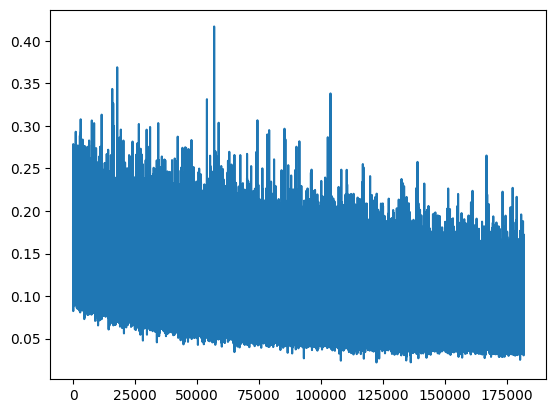

In [147]:
plt.plot(lossi)

In [148]:
# Evaluation

with torch.no_grad():
    out = cov_test @ W + b
    out = F.relu(out)
    out = out @ W2 + b2
    loss_test = (out - trg_test).pow(2).mean()

print(loss_test)

tensor(0.0488)


In [150]:
px.line(np.concatenate([out.numpy(), trg_test.numpy()], axis=1))

## From Linear Regression to Neural Network

In [152]:
from torch.optim import Adam

model = nn.Sequential(nn.Linear(fan_in, fan_out), nn.ReLU(), nn.Linear(fan_out, fan_out))
opt = Adam(model.parameters(), lr=0.0001)
lossi = []
for i in range(1000):
    for cov_batch, trg_batch in dl:
        out = model(cov_batch)
        loss = (out - trg_batch).pow(2).mean()
        loss.backward()
        lossi.append(loss.item())
        opt.step()
        opt.zero_grad()
        
        

In [153]:
with torch.no_grad():
    out = model(cov_test)
    loss_test = (out - trg_test).pow(2).mean()

In [154]:
px.line(np.concatenate([out.numpy(), trg_test.numpy()], axis=1))